In [1]:
import torch
import os
os.environ['NEURITE_BACKEND'] = 'pytorch'
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm
import matplotlib.pyplot as plt
import glob
import re
import csv
from tifffile import imwrite
import numpy as np
from PIL import Image
import fnmatch
from collections import defaultdict
import shutil

from my_utils_v2 import Utils_v2

Original Tissue Path

In [4]:
tissue_path='/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered'
tissue_name='GCA002ACB'
mask_path=f'/fs5/p_masi/baos1/rudravg/MXIF/MXIF/Helmsley/MxIF/Set01/GCA002ACB/Registered/{tissue_name}_RetentionMask.tif'
output_path='/fs5/p_masi/rudravg/MxIF_Vxm_Registered'

Getting all Tissues

In [5]:
all_tissues=[]
for file in os.listdir(tissue_path):
    if fnmatch.fnmatch(file, '*.tif'):
        all_tissues.append(os.path.join(tissue_path, file))

Putting each DAPI and it's corresponding stains into an array

In [6]:
filtered_tissues = list(filter(lambda x: 'RetentionMask' not in x, all_tissues))

# Group the strings by round number
tissues_by_round = defaultdict(list)
for tissue in filtered_tissues:
    round_number = int(re.search('ROUND_(\\d+)', tissue).group(1))
    tissues_by_round[round_number].append(tissue)

# Sort the dictionary items by key (round number)
sorted_items = sorted(tissues_by_round.items())

# Sort each group so that the string containing "DAPI_DAPI" comes first, and convert the sorted dictionary items to a list
grouped_tissues = [sorted(group, key=lambda x: f'{tissue_name}_DAPI' not in x) for _, group in sorted_items]


Declaring the Round 0 DAPI and Registering the DAPI's and stains together

In [7]:
round0_dapi = grouped_tissues[0][0]
round0_dapi,height,width = Utils_v2.load_tissues_for_overlap(round0_dapi,mask_path)

In [15]:
np.unique(round0_dapi)

array([0.        , 0.00392157, 0.00784314, 0.01176471, 0.01568628,
       0.01960784, 0.02352941, 0.02745098, 0.03137255, 0.03529412,
       0.03921569, 0.04313726, 0.04705882, 0.05098039, 0.05490196,
       0.05882353, 0.0627451 , 0.06666667, 0.07058824, 0.07450981,
       0.07843138, 0.08235294, 0.08627451, 0.09019608, 0.09411765,
       0.09803922, 0.10196079, 0.10588235, 0.10980392, 0.11372549,
       0.11764706, 0.12156863, 0.1254902 , 0.12941177, 0.13333334,
       0.13725491, 0.14117648, 0.14509805, 0.14901961, 0.15294118,
       0.15686275, 0.16078432, 0.16470589, 0.16862746, 0.17254902,
       0.1764706 , 0.18039216, 0.18431373, 0.1882353 , 0.19215687,
       0.19607843, 0.2       , 0.20392157, 0.20784314, 0.21176471,
       0.21568628, 0.21960784, 0.22352941, 0.22745098, 0.23137255,
       0.23529412, 0.23921569, 0.24313726, 0.24705882, 0.2509804 ,
       0.25490198, 0.25882354, 0.2627451 , 0.26666668, 0.27058825,
       0.27450982, 0.2784314 , 0.28235295, 0.28627452, 0.29019

In [8]:
model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/trial2_epochs/epoch_113/epoch_113.pth'
model,device=Utils_v2.load_model(model_path) #Write this code

/home/local/VANDERBILT/rudravg/miniconda3/envs/dapi_reg/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


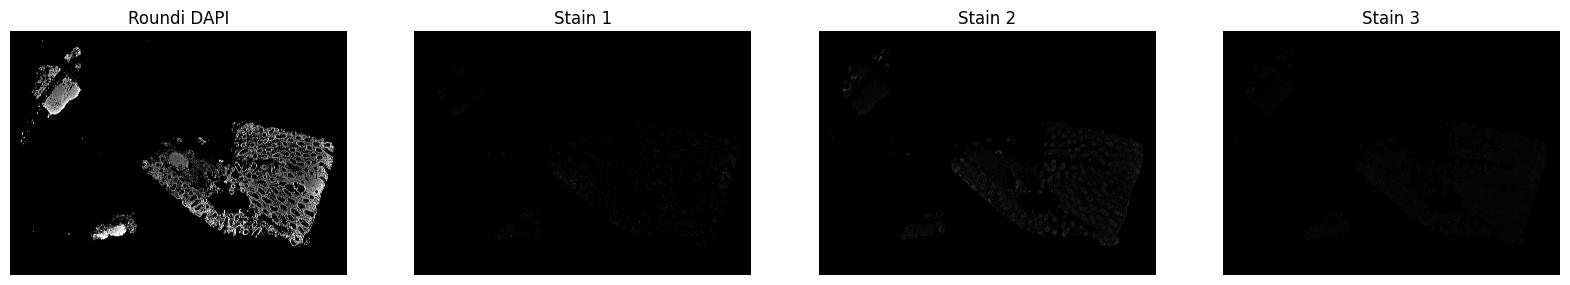

In [9]:

roundi_dapi = grouped_tissues[1][0]
stain1=grouped_tissues[1][1]
stain2=grouped_tissues[1][2]
stain3=grouped_tissues[1][3]

roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
stain3,_,_ = Utils_v2.load_tissues_for_overlap(stain3,mask_path)
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(roundi_dapi, cmap='gray')
axs[0].set_title('Roundi DAPI')

axs[1].imshow(stain1, cmap='gray')
axs[1].set_title('Stain 1')

axs[2].imshow(stain2, cmap='gray')
axs[2].set_title('Stain 2')

axs[3].imshow(stain3, cmap='gray')
axs[3].set_title('Stain 3')

for ax in axs:
    ax.axis('off')

plt.show()



In [10]:
registered_dapi,registered_stain1,registered_stain2,registered_stain3=Utils_v2.register_multiple_tissues_with_overlap(moving=roundi_dapi,fixed=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,stain3=stain3,model=model,device=device)

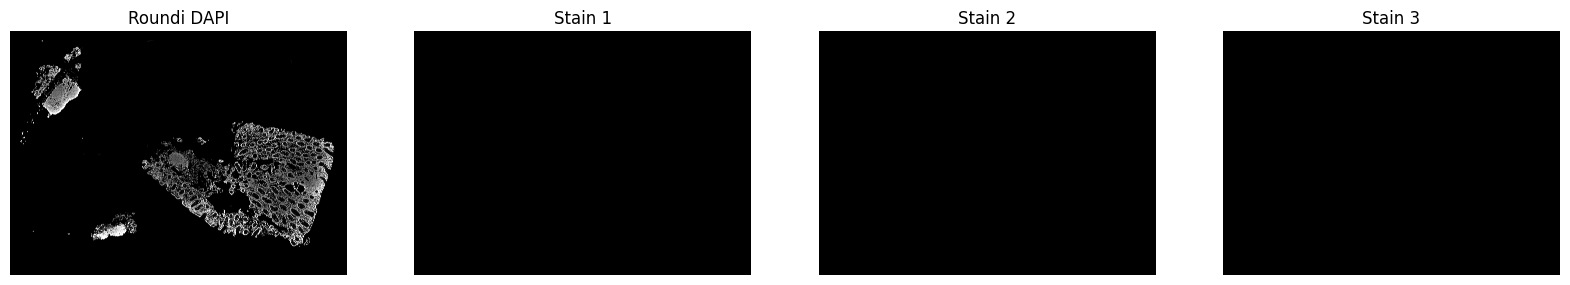

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(registered_dapi, cmap='gray')
axs[0].set_title('Roundi DAPI')

axs[1].imshow(registered_stain1, cmap='gray')
axs[1].set_title('Stain 1')

axs[2].imshow(registered_stain2, cmap='gray')
axs[2].set_title('Stain 2')

axs[3].imshow(registered_stain3, cmap='gray')
axs[3].set_title('Stain 3')

for ax in axs:
    ax.axis('off')

plt.show()

In [12]:
np.unique(registered_stain1)

array([0.], dtype=float32)

Copy the paths related to Round0, since we are not applying any transformations on them

In [13]:
new_dir = os.path.join(output_path, tissue_name)
os.makedirs(new_dir, exist_ok=True)

for file_path in grouped_tissues[0]:
    shutil.copy(file_path, new_dir)

Now comes the actual registration lesgo

In [16]:
model_path='/home-local/rudravg/test_DAPI/1024_Dataset_V2/trial2_epochs/epoch_113/epoch_113.pth'
model,device=Utils_v2.load_model(model_path) #Write this code
i=0
for group in grouped_tissues[1:]:
    stains=len(group)
    i+=1
    print(f"Registering Round {i}, which has {stains} number of stains")
    if stains==1:
        print("Bruh where are all the tissues")
    elif stains==2:
        roundi_dapi = group[0]
        stain1=group[1]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        registered_dapi,registered_stain1=Utils_v2.register_multiple_tissues_with_overlap(moving=roundi_dapi,fixed=round0_dapi,
                                                                                          stain1=stain1,model=model,device=device)
    elif stains==3:
        roundi_dapi = group[0]
        stain1=group[1]
        stain2=group[2]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
        registered_dapi,registered_stain1,registered_stain2=Utils_v2.register_multiple_tissues_with_overlap(moving=roundi_dapi,fixed=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,model=model,device=device)
    elif stains==4:
        roundi_dapi = group[0]
        stain1=group[1]
        stain2=group[2]
        stain3=group[3]
        roundi_dapi,_,_ = Utils_v2.load_tissues_for_overlap(roundi_dapi,mask_path)
        stain1,_,_ = Utils_v2.load_tissues_for_overlap(stain1,mask_path)
        stain2,_,_ = Utils_v2.load_tissues_for_overlap(stain2,mask_path)
        stain3,_,_ = Utils_v2.load_tissues_for_overlap(stain3,mask_path)
        registered_dapi,registered_stain1,registered_stain2,registered_stain3=Utils_v2.register_multiple_tissues_with_overlap(moving=roundi_dapi,fixed=round0_dapi,
                                                                                          stain1=stain1,stain2=stain2,stain3=stain3,model=model,device=device)
        print(os.path.join(new_dir, f"{group[0]}"))

Registering Round 1, which has 3 number of stains


ValueError: operands could not be broadcast together with shapes (3496,3496) (3349,3177) 